# IEEE-CIS Fraud Detection



## 1. Business Problem 
### 1.1. Description 

**Source:** https://www.kaggle.com/c/ieee-fraud-detection/overview

---

Imagine standing at the check-out counter at the grocery store with a long line behind you and the cashier not-so-quietly announces that your card has been declined. In this moment, you probably aren’t thinking about the data science that determined your fate.

While perhaps cumbersome (and often embarrassing) in the moment, this fraud prevention system is actually saving consumers millions of dollars per year. Researchers from the IEEE Computational Intelligence Society (IEEE-CIS) want to improve this figure, while also improving the customer experience. With higher accuracy fraud detection, you can get on with your chips without the hassle.




> Credits: Kaggle

#### Problem Statement
* Make e-commerce safer by detecting fraud detection in real time and accurately.

### 1.2. Sources/Useful Links
* https://www.kaggle.com/c/ieee-fraud-detection/data
* https://www.kaggle.com/c/ieee-fraud-detection/discussion/111284#latest-670375
* https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600/output
* https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-671062
* https://www.kaggle.com/c/ieee-fraud-detection/discussion/99979#latest-648115
*https://www.kaggle.com/c/ieee-fraud-detection/discussion/111308#latest-664620

### 1.3 Real world/Business Objectives and constraints 
* Precisely detect a fraud transaction.


## 2. Machine Learning Probelm 
### 2.1. Data Information

**Source**: https://www.kaggle.com/c/ieee-fraud-detection/data

---

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

### Categorical Features - Transaction
* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

### Categorical Features - Identity
* DeviceType
* DeviceInfo
* id_12 - id_38

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

### 2.2. Mapping the real world problem to an ML problem
* It is a binary classification problem, for a transaction we need to predict if it is fraud or not.

### 2.2.2 Performance Metric

**Source:** https://www.kaggle.com/c/ieee-fraud-detection/overview/evaluation

**Metric:**

* area under the ROC curve

### 2.3 Train and Test Construction

We build train and test by time stamp based splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.

In [0]:
#importing some useful libraries
import time
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import datetime
import math
import pickle
from sklearn.metrics import roc_curve
import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [90]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Load Data

In [91]:
train_transaction = pd.read_csv('/content/drive/My Drive/IEEE_F/train_transaction.csv')
train_identity = pd.read_csv('/content/drive/My Drive/IEEE_F/train_identity.csv')

df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
del train_transaction, train_identity
gc.collect()

cat_ft = ['ProductCD','addr1','addr2','P_emaildomain','R_emaildomain','DeviceType','DeviceInfo']+['card'+str(x) for x in range(1,7)] + ['M'+str(x) for x in range(1,10)] + ['id_'+str(x) for x in range(12,39)]

print('train set shape:', df.shape)

train set shape: (590540, 434)


In [92]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### EDA

percentage of fraud transaction = 3.499000914417313 %
isFraud
0    569877
1     20663
Name: TransactionID, dtype: int64


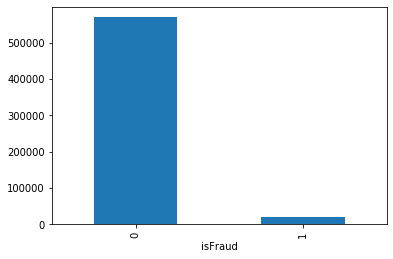

In [93]:
cnt = df.groupby("isFraud")['TransactionID'].count()
cnt.plot.bar()
rt = (cnt[1]*100)/(cnt[0]+cnt[1])
print("percentage of fraud transaction = {} %".format(rt))
print(cnt)

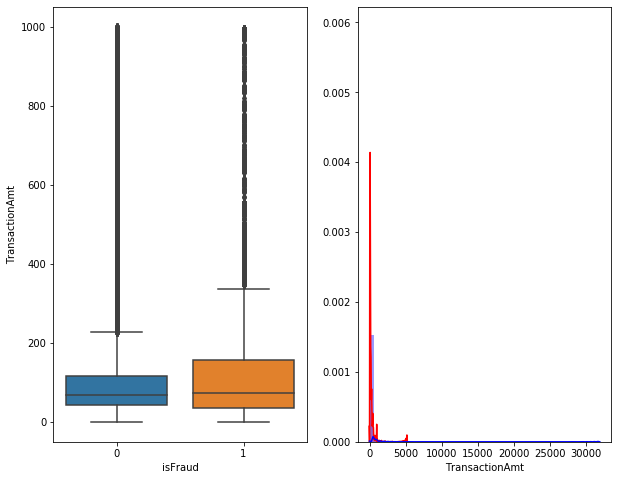

In [94]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.boxplot(x = 'isFraud', y = 'TransactionAmt', data = df[df['TransactionAmt'] <1000],showbox=True )

plt.subplot(1,2,2)
sns.distplot(df[df['isFraud'] == 1.0]['TransactionAmt'][0:] , label = "1", color = 'red')
sns.distplot(df[df['isFraud'] == 0.0]['TransactionAmt'][0:] , label = "0" , color = 'blue' )
plt.show()


<function matplotlib.pyplot.show>

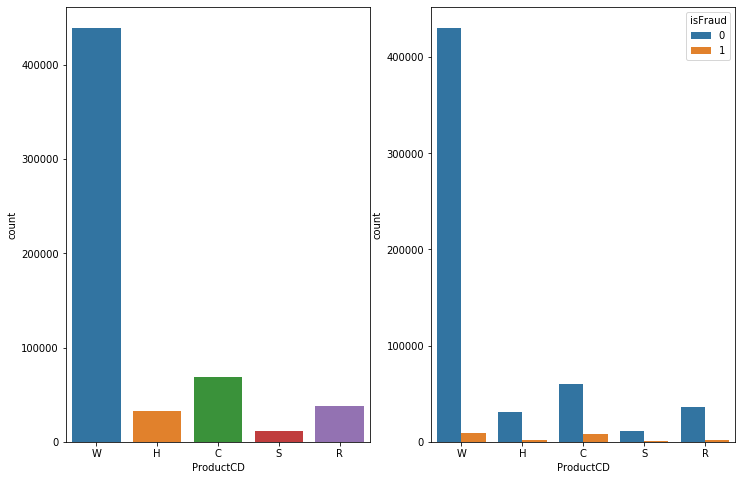

In [95]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.countplot(x='ProductCD', data=df)
plt.subplot(1,2,2)
sns.countplot(x='ProductCD', hue='isFraud', data=df)
plt.show

<function matplotlib.pyplot.show>

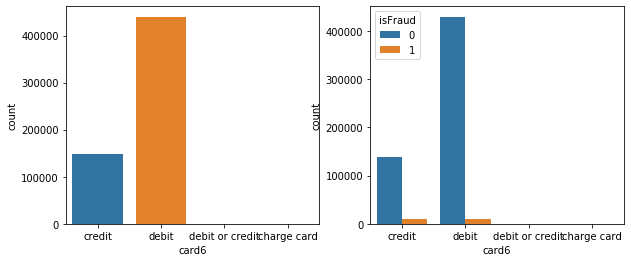

In [96]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
sns.countplot(x='card6', data=df)
plt.subplot(1,2,2)
sns.countplot(x='card6', hue='isFraud', data=df)
plt.show

isFraud
0    45
1    31
Name: TransactionID, dtype: int64
 0.41 percent of transactionID having protonmail.com as P_emaildomain is fraud 


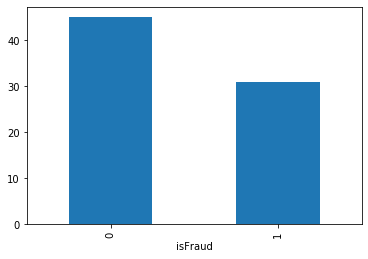

In [97]:
cnt = df.groupby("P_emaildomain").get_group('protonmail.com').groupby('isFraud')['TransactionID'].count()
a =cnt[1]/(cnt[0]+cnt[1])
cnt.plot.bar()
print(cnt)
print('='*50)
print(' %.2f percent of transactionID having protonmail.com as P_emaildomain is fraud ' % a)
print('='*50)

isFraud
0     2
1    39
Name: TransactionID, dtype: int64
 0.95 percent of transactionID having protonmail.com as R_emaildomain is fraud 


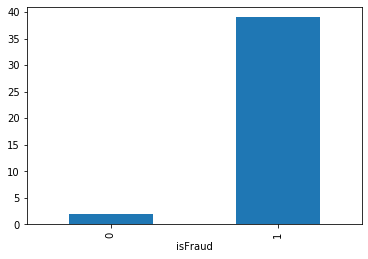

In [98]:
cnt = df.groupby("R_emaildomain").get_group('protonmail.com').groupby('isFraud')['TransactionID'].count()
a =cnt[1]/(cnt[0]+cnt[1])
cnt.plot.bar()
print(cnt)
print('='*50)
print(' %.2f percent of transactionID having protonmail.com as R_emaildomain is fraud ' % a)
print('='*50)

In [99]:
print(f'There are {df.isnull().any().sum()} columns in our dataset with missing values.')

There are 414 columns in our dataset with missing values.


In [0]:
#https://pandas-profiling.github.io/pandas-profiling/docs/
#open report for more eda.

"""
import pandas_profiling
profDf = pandas_profiling.ProfileReport(df)
profDf.to_file(outputfile='/content/drive/My Drive/IEEE_F/report.html')
rejected_variables = profDf.get_rejected_variables(threshold=0.9)
"""

In [0]:
rejected_variables = ['V2', 'V5', 'V7', 'V9', 'V10', 'V12', 'V15', 'V16', 'V18', 'V19', 'V21', 'V22', 'V24', 'V25', 'V28', 'V29', 'V31', 'V32', 'V33', 'V34', 'V35', 'V38', 'V39', 'V42', 'V43', 'V45', 'V46', 'V49', 'V50', 'V51', 'V52', 'V53', 'V55', 'V57', 'V58', 'V60', 'V61', 'V63', 'V64', 'V66', 'V69', 'V71', 'V72', 'V73', 'V74', 'V75', 'V77', 'V79', 'V81', 'V83', 'V84', 'V85', 'V87', 'V90', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V109', 'V110', 'V112', 'V113', 'V114', 'V116', 'V118', 'V119', 'V122', 'V125', 'V126', 'V128', 'V131', 'V132', 'V133', 'V134', 'V135', 'V137', 'V140', 'V141', 'V143', 'V144', 'V145', 'V146', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V157', 'V158', 'V159', 'V161', 'V163', 'V164', 'V167', 'V168', 'V170', 'V172', 'V174', 'V177', 'V179', 'V181', 'V183', 'V184', 'V186', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V199', 'V200', 'V201', 'V202', 'V204', 'V206', 'V208', 'V211', 'V212', 'V213', 'V214', 'V216', 'V217', 'V219', 'V222', 'V225', 'V227', 'V230', 'V231', 'V232', 'V233', 'V236', 'V237', 'V239', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V251', 'V254', 'V255', 'V256', 'V259', 'V262', 'V263', 'V265', 'V268', 'V269', 'V270', 'V272', 'V273', 'V275', 'V276', 'V278', 'V279', 'V280', 'V282', 'V287', 'V288', 'V290', 'V292', 'V293', 'V295', 'V298', 'V299', 'V300', 'V302', 'V304', 'V306', 'V308', 'V311', 'V312', 'V313', 'V315', 'V316', 'V317', 'V318', 'V319', 'V321', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339','D6','D7','D8','D9','D12','D13','D14','C3','M5','id_08','id_33','card4','id_07','id_14','id_21','id_30','id_32','id_34','id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']

In [101]:
del df
gc.collect()


29671

#### Summary
* Data is imbalanced.
* There are 414 columns in our dataset with missing values.
* Number of observations are	590540
* Data have 25.4% missing values.
* W category of feature ProductCD is dominating over other.
* V features are highly correlated.
* Debit card transactions are more than credit card transactions.
* Transactions having P_emaildomain or R_emaildomain as protonmail.com have high chances of being fraud

##Feature Enginering & Data Prepration

In [102]:
# LOAD TRAIN
X_train = pd.read_csv('/content/drive/My Drive/IEEE_F/train_transaction.csv',index_col='TransactionID')
train_id = pd.read_csv('/content/drive/My Drive/IEEE_F/train_identity.csv',index_col='TransactionID')
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('/content/drive/My Drive/IEEE_F/test_transaction.csv',index_col='TransactionID')
test_id = pd.read_csv('/content/drive/My Drive/IEEE_F/test_identity.csv',index_col='TransactionID')
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 432) test shape (506691, 432)


In [0]:
cat_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
for col in X_train.columns:
  if col in cat_type:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
  else:
    X_train[col] = X_train[col].astype('float32')
    X_test[col] = X_test[col].astype('float32')

In [0]:
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if f in cat_type : 
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
        
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

In [0]:
#normalising D columns so it will not increase with time
#https://www.kaggle.com/c/ieee-fraud-detection/discussion/100775#latest-604205
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60)

In [0]:
# FREQUENCY ENCODE TOGETHER
#https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600/output
def freq_encode(df1, df2, cols):
  """count of total no of appearnce of a value in a given column in whole dataset(test+train)"""
  for col in cols:
    df = pd.concat([df1[col],df2[col]])
    vc = df.value_counts(dropna=True, normalize=True).to_dict() #creating a dict with feature value as key and feature vake count as value.
    vc[-1] = -1   #for nan values
    cn = col+'_FE'
    df1[cn] = df1[col].map(vc)  #mapping values according to feature value
    df1[cn] = df1[cn].astype('float32')   #storing in float 32 format
    df2[cn] = df2[col].map(vc)
    df2[cn] = df2[cn].astype('float32')
    print(cn,', ',end='')

# LABEL ENCODE
def label_encode(col,train=X_train,test=X_test,verbose=True):
  """this function perform label encoding"""
  df_comb = pd.concat([train[col],test[col]],axis=0)
  df_comb,_ = df_comb.factorize(sort=True)
  cn = col
  if df_comb.max()>32000: #checking the max value so that we can reduce memory usage
    train[cn] = df_comb[:len(train)].astype('int32')
    test[cn] = df_comb[len(train):].astype('int32')
  else:
    train[cn] = df_comb[:len(train)].astype('int16')
    test[cn] = df_comb[len(train):].astype('int16')
  del df_comb; x=gc.collect()
  if verbose: print(cn,', ',end='')

# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    """AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    we made group based on uid and then aggregate the value of column and then add it in dataset as new feature"""
    for main_column in main_columns:
      for col in uids:
        for agg_type in aggregations:
          new_col_name = main_column+'_'+col+'_'+agg_type
          temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
          if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
          temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name}) #taking aggregation according to group by col 

          temp_df.index = list(temp_df[col])
          temp_df = temp_df[new_col_name].to_dict()   

          train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
          test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
          if fillna:
            train_df[new_col_name].fillna(-1,inplace=True)
            test_df[new_col_name].fillna(-1,inplace=True)
         
          print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def comb_ftr(col1,col2,df1=X_train,df2=X_test):
  """this function is used for combining two feature value"""
  cn = col1+'_'+col2
  df1[cn] = df1[col1].astype(str)+'_'+df1[col2].astype(str) # combining two feature value with _ as sepration
  df2[cn] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
  label_encode(cn,verbose=False)
  print(cn,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
#https://stackoverflow.com/questions/18554920/pandas-aggregate-count-distinct
def AG_enc_nunq(main_columns, uids, train_df=X_train, test_df=X_test):
  """AGGREGATION OF MAIN WITH UID FOR UNIQUE VALUE COUNT"""
  for main_column in main_columns:  
    for col in uids:
      comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
      mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
      train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
      test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
      print(col+'_'+main_column+'_ct, ',end='')

**What is UIDS?**

uids are like user identification they help us to identify a user if user done some fraud all the transaction by that user marked as fraud there are some feature in our data set which gave us idea about the use so we use combination of these feature as uids.

**Functions :**

**freq_encode :** count of total no of appearnce of a value in a given column in whole dataset(test+train) and add it as a new feature.

**comb_ftr :** this function take value from two feature and combine them with _ in between to create a new feature.



**encode_AG :** encode_AG function create group by uids and take aggregation for main columns on whole dataset for each value in uids,maincolumns and aggregation.

**AG_enc_nunq :** AG_enc_nunq first make group by uids and than store number of unique vale of main columns in a dict and add them as new feature.

In [107]:
# these feature enginering are based on EDA and kaggle disscusion
X_train['P_isproton']=(X_train['P_emaildomain']=='protonmail.com')
X_test['P_isproton']=(X_test['P_emaildomain']=='protonmail.com')
print('P_isproton, ', end='')
X_train['R_isproton']=(X_train['R_emaildomain']=='protonmail.com')
X_test['R_isproton']=(X_test['R_emaildomain']=='protonmail.com')
print('R_isproton, ', end='')
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')

P_isproton, R_isproton, cents, 

In [108]:
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
freq_encode(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
comb_ftr('card1','addr1')
comb_ftr('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
freq_encode(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , 

In [0]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month

In [0]:
#https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600/output
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

In [111]:
# FREQUENCY ENCODE UID
freq_encode(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
# AGGREGATE
AG_enc_nunq(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE 
AG_enc_nunq(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREATE 
AG_enc_nunq(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_id_02_ct, uid_cents_ct, 'C14_uid_std' , uid_C13_ct, uid_V314_ct, uid_V127_ct, uid_V136_ct, uid_V309_ct, uid_V307_ct, uid_V320_ct, outsider15


In [0]:
drop_variables = rejected_variables + ['DT_M', 'TransactionDT', 'day', 'uid'] #removing this extra variables uid ,day etc to avoid overfitting

In [0]:
cols = list( X_train.columns )
for c in drop_variables:
    cols.remove(c)

# Modeling

## Logestic Regression

### With Class Balancing

In [0]:
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}] #values of hyperparameter for tunning
gkf=GroupKFold(n_splits=5)
clf = LogisticRegression(penalty='l2',class_weight='balanced') #define classifier
model = GridSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=gkf) #cross validation
model.fit(X_train[cols].iloc[:442905], y_train[:442905], groups=X_train.iloc[:442905]['DT_M'])

print(model.best_estimator_)
print(model.score(X_train[cols].iloc[442905:], y_train[442905:]))

LogisticRegression(C=100000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.812414641880185


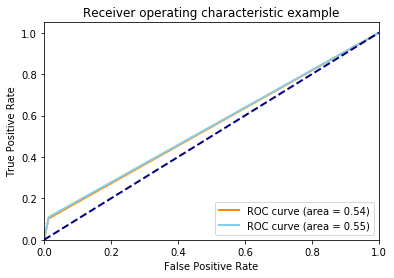

[[110864  31671]
 [  1470   3630]]


In [0]:
plt.figure()
lw = 2

#ROC_AUC curve
# plot for test

pred = model.predict(X_train[cols].iloc[442905:])
fpr, tpr, thresholds = roc_curve(pred, y_train[442905:])
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

#plot for train

pred = model.predict(X_train[cols].iloc[:442905])
fpr, tpr, thresholds = roc_curve(pred, y_train[:442905])
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='skyblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#confusion_matrix
pred = model.predict(X_train[cols].iloc[442905:])
CM = confusion_matrix(y_train[442905:], pred)
print(CM)

### Without Class Balancing

In [0]:
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}] #values of hyperparameter for tunning
gkf=GroupKFold(n_splits=5)
clf = LogisticRegression(penalty='l2') #define classifier
model = GridSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=gkf) #cross validation
model.fit(X_train[cols].iloc[:442905], y_train[:442905], groups=X_train.iloc[:442905]['DT_M'])

print(model.best_estimator_)
print(model.score(X_train[cols].iloc[442905:], y_train[442905:]))

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.7666879897957606


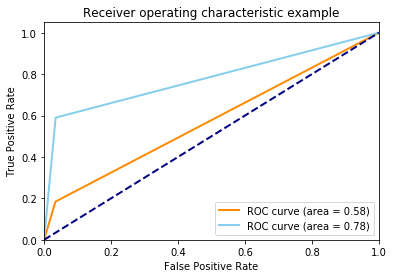

[[142106    429]
 [  5003     97]]


In [0]:
plt.figure()
lw = 2

#ROC_AUC curve
# plot for test

pred = model.predict(X_train[cols].iloc[442905:])
fpr, tpr, thresholds = roc_curve(pred, y_train[442905:])
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

#plot for train

pred = model.predict(X_train[cols].iloc[:442905])
fpr, tpr, thresholds = roc_curve(pred, y_train[:442905])
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='skyblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#confusion_matrix
pred = model.predict(X_train[cols].iloc[442905:])
CM = confusion_matrix(y_train[442905:], pred)
print(CM)

## XGBOOST

### With Class Balancing

In [124]:
tuned_parameters = {'max_depth': [5,7,9,12],'n_estimators':[100,500,2000,5000]} #values of hyperparameter for tunning
gkf=GroupKFold(n_splits=5)
clf = xgb.XGBClassifier(learning_rate=0.02,
                        subsample=0.8,
                        colsample_bytree=0.4,
                        scale_pos_weight = 5.25, #scale_pos_weight=sqrt(count(negative)/count(positive))
                        missing =-1,
                        tree_method='gpu_hist') #define classifier
model = RandomizedSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=gkf) #cross validation
model.fit(X_train[cols].iloc[:442905], y_train[:442905], groups=X_train.iloc[:442905]['DT_M'])

print(model.best_estimator_)
print(model.score(X_train[cols].iloc[442905:], y_train[442905:]))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-1, n_estimators=5000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5.25, seed=None,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=1)
0.9460101732906239


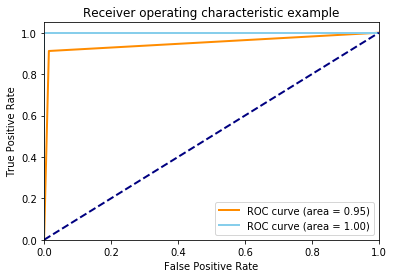

[[142242    293]
 [  2072   3028]]


In [0]:
plt.figure()
lw = 2

#ROC_AUC curve
# plot for test

pred = model.predict(X_train[cols].iloc[442905:])
fpr, tpr, thresholds = roc_curve(pred, y_train[442905:])
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

#plot for train

pred = model.predict(X_train[cols].iloc[:442905])
fpr, tpr, thresholds = roc_curve(pred, y_train[:442905])
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='skyblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#confusion_matrix
pred = model.predict(X_train[cols].iloc[442905:])
CM = confusion_matrix(y_train[442905:], pred)
print(CM)

### Without Class Balancing

In [125]:
tuned_parameters = {'max_depth': [5,7,9,12],'n_estimators':[100,500,2000,5000]} #values of hyperparameter for tunning
gkf=GroupKFold(n_splits=5)
clf = xgb.XGBClassifier(learning_rate=0.02,
                        subsample=0.8,
                        colsample_bytree=0.4,
                        missing =-1,
                        tree_method='gpu_hist') #define classifier
model = RandomizedSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=gkf) #cross validation
model.fit(X_train[cols].iloc[:442905], y_train[:442905], groups=X_train.iloc[:442905]['DT_M'])

print(model.best_estimator_)
print(model.score(X_train[cols].iloc[442905:], y_train[442905:]))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=-1, n_estimators=5000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=1)
0.9650921055506257


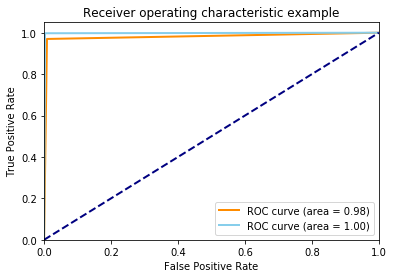

[[142415    120]
 [  1241   3859]]


In [122]:
plt.figure()
lw = 2

#ROC_AUC curve
# plot for test

pred = model.predict(X_train[cols].iloc[442905:])
fpr, tpr, thresholds = roc_curve(pred, y_train[442905:])
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

#plot for train

pred = model.predict(X_train[cols].iloc[:442905])
fpr, tpr, thresholds = roc_curve(pred, y_train[:442905])
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='skyblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#confusion_matrix
pred = model.predict(X_train[cols].iloc[442905:])
CM = confusion_matrix(y_train[442905:], pred)
print(CM)

In [0]:
preds = model.predict_proba(X_test[cols])[:,1]
sample_submission = pd.read_csv('/content/drive/My Drive/IEEE_F/sample_submission.csv')
sample_submission.isFraud = preds
sample_submission.to_csv('/content/drive/My Drive/IEEE_F/xgb_my_submission00.csv',index=False)

# Conclusion
* our best model is xgboost without class balancing

## Steps:
* Load Data.
* Perform EDA.
* Perform Feature engineering.
* Prepare Data for models.
* Try different models.

In [126]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Models", "Score"]
x.add_row(["LR", 0.766])
x.add_row(["LR + CB", 0.812])
x.add_row(["XGBOOST", 0.965])
x.add_row(["XGBOOST + CB", 0.946])
print('All Model Comparison')
print(x)

All Model Comparison
+--------------+-------+
|    Models    | Score |
+--------------+-------+
|      LR      | 0.766 |
|   LR + CB    | 0.812 |
|   XGBOOST    | 0.965 |
| XGBOOST + CB | 0.946 |
+--------------+-------+
